## Stock selection and strategy according to Hossein PTS Cointegration 

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
from cointegration_functions import * 
from kalman_functions import *

def run_strategy_kalman(stocks: pd.DataFrame):
    stocks.index = pd.to_datetime(stocks.index)
    time_frame = stocks.index

    months = pd.Series(time_frame).dt.to_period('M').unique()  # Extract unique months

    # This is the main dataframe, that stores the daily returns of each portfolio 
    returns_dictionary = {}

    n_trading_periods = 0 

    # Iterate through months instead of days
    for start_idx in range(len(months)):

        formation_start = pd.Timestamp(months[start_idx].start_time)
        formation_end = formation_start + pd.DateOffset(months=24)-pd.DateOffset(days=1)  # 24 months later
        trading_start = formation_start + pd.DateOffset(months=24)
        trading_end = formation_end + pd.DateOffset(months=6)  # Next 6 months
        
        # Ensure we don't exceed the timeframe
        if trading_end > time_frame[-1]:
            break
        
        # The backtest algorithm starts here:
        # 1. normalize the stock data at the start of the formation period to 1$  
        stocks_normalized = normalize(stocks.loc[formation_start:trading_end])

        # Select formation period data   
        stocks_formation = stocks_normalized.loc[formation_start:formation_end]
        # Select testing data (next 6 months)
        stocks_trading = stocks_normalized.loc[trading_start:trading_end]
        
        # Formation part 
        # 2. sort by ssd ~ 1 minute
        print("\nSorting all combinations by SSD...\n")
        print("=" * 80)
        pairs_sorted = calculate_and_sort_ssd(stocks_formation)

        print(f"Formation Start:\n{stocks_formation.index[0]}")
        print("X" * 80)

        # 3. Select 20 cointegrated pairs 
        print("\nSelecting cointegrated pairs using Engle-Kranger method...\n")
        print("=" * 80)
        portfolio = select_cointegrated_pairs(stocks_formation, pairs_sorted)

        # 4. Estimate the state - observation model parameters
        print("\nEstimating the state - observation model parameters...\n")
        print("=" * 80)
        portfolio_models = estimate_model(stocks_formation=stocks_formation,portfolio=portfolio)
        
        print(f"Formation End:\n{stocks_formation.index[-1]}")
        print("-" * 80)
        print(f"Trading Start:\n{stocks_trading.index[0]}")

        # Trading part
        # 5. Trade portfolio
        print("\nPortfolio is trading...\n")
        print("=" * 80)
        _, _, _, result_df, _  = trade_portfolio_kalman(portfolio_models, stocks_trading=stocks_trading)

        print(f"Trading End:\n{stocks_trading.index[-1]}\n")
        print("X" * 80)

        # 6. Calculate daily returns of each portfolio and append this column for each trading period
        # calculated as a row sums of the daily returns of 20 pairs 
        returns_dictionary[f"Portfolio_{trading_start}"] = result_df.sum(axis=1)
        n_trading_periods += 1
        print("Number of trading periods: ", n_trading_periods) 

    return pd.DataFrame(returns_dictionary)

In [ ]:

#stocks_1990_2025 = pd.read_csv("C:/Users/adamt/OneDrive/Desktop/Jakub/masterThesis/stocks_1990_2025.csv",index_col = 0)
#backtest_result_1990_2025 = run_strategy_kalman(stocks_1990_2025)
#backtest_result_1990_2025.to_csv("C:/Users/adamt/OneDrive/Desktop/Jakub/masterThesis/backtestfrom1990to2025_result_kalman.csv")
#backtest_result_1990_2025

3100.3085796401883
(8309, 391)


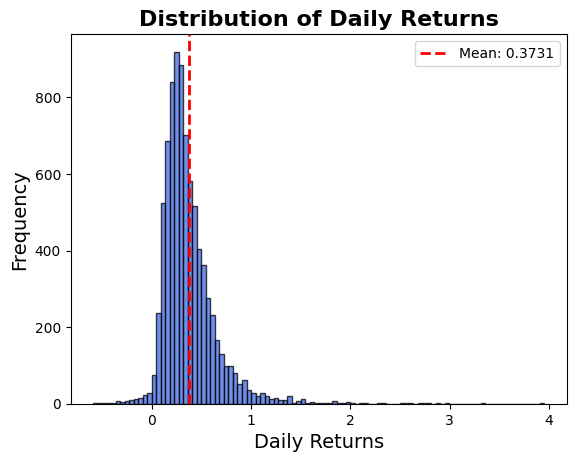

In [5]:
backtest_result_1990_2025 = pd.read_csv("C:/Users/adamt/OneDrive/Desktop/Jakub/masterThesis/backtestfrom1990to2025_result_kalman.csv",index_col = 0)

# Daily returns of the 6 overlapping portfolios for the selected time frame. 
daily_returns = pd.DataFrame(backtest_result_1990_2025).sum(axis=1)
daily_returns_hist = daily_returns[daily_returns !=0]

print(sum(daily_returns))
print(backtest_result_1990_2025.shape)
plt.hist(daily_returns_hist, bins=100, color="royalblue", edgecolor="black", alpha=0.75)

# Labels and title
plt.xlabel("Daily Returns", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Daily Returns", fontsize=16, fontweight="bold")
plt.axvline(daily_returns.mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean: {daily_returns.mean():.4f}")
plt.legend()

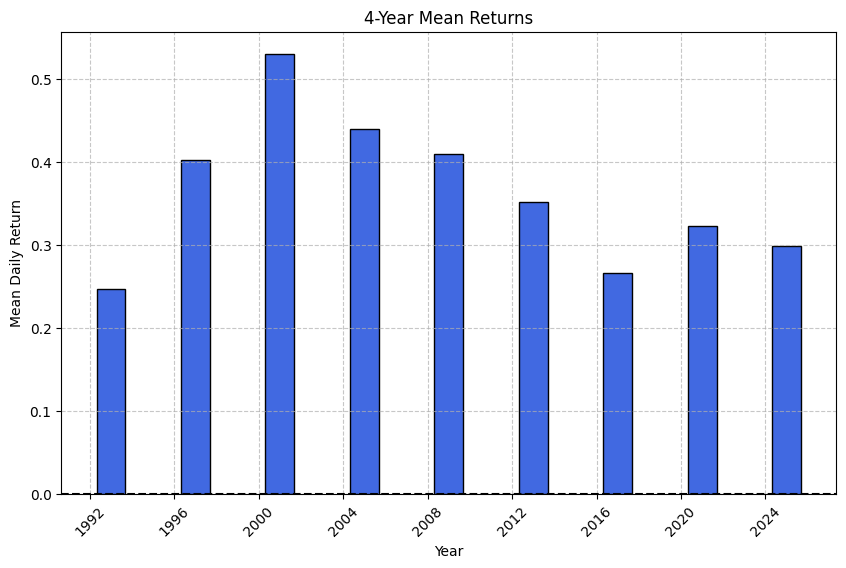

In [6]:
daily_returns_hist = daily_returns_hist[daily_returns_hist.index < "2025-01-01"]
daily_returns_hist.index = pd.to_datetime(daily_returns_hist.index)
yearly_returns = daily_returns_hist.resample("4YE").mean()

# Bar plot of 4-year mean returns
plt.figure(figsize=(10, 6))  # Adjust figure size for better clarity
plt.bar(yearly_returns.index - pd.DateOffset(years=0), yearly_returns.values, width = 500, color='royalblue', edgecolor='black', label='4-Year Mean Return')
plt.axhline(0, color='black', linestyle='--')  # Reference line at 0
plt.xlabel("Year")
plt.ylabel("Mean Daily Return")
plt.title("4-Year Mean Returns")
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.show()